In [38]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import jit, lax, vmap, jacobian
import jax.scipy.linalg as jsl

import jax

import numpy as np
from read_traj_v2 import *

import scipy.optimize

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [39]:
mol = 'heh+'
basis = 'sto-3g'
init = 'hf'
td = 'rt-tdexx'

dt = 0.08268/10

inpath = './correctdata'
inpath2 = './mydata/'
outpath = './'
saved_model_dir = './models/'

trnfrq = jnp.array(np.load('./tdcis_data/tdcis_trnfreq_dt0.008268.npz'))
trnamp = jnp.array(np.load('./tdcis_data/tdcis_trnamp_dt0.008268.npz'))
trntme = jnp.array(np.load('./tdcis_data/tdcis_trntme_dt0.008268.npz'))
# load important static matrices
a = traj_data(inpath, mol, basis, init, td, '001',
                init_cond_file=f'ke+en+overlap+ee_twoe+dip_casscf22_{mol}_{basis}.npz',
                )
a.assign_init_data()
drc = a.drc
xmat, didat, kinmat, enmat = a.xmat, a.didat, a.kinmat, a.enmat
X = xmat


	reading from "./correctdata/ke+en+overlap+ee_twoe+dip_casscf22_heh+_sto-3g.npz"

can only concatenate str (not "NoneType") to str
True is not in list


In [40]:
trnden = jnp.array(np.load('./tdcis_data/tdcis_dt0.0082680.npz'))
#trnden = jnp.array(np.load('./tdhf_data/rt-tdhf_forcing_full_finedt.npz'))
print(trnden.shape)

(301, 10000, 2, 2)


In [41]:
inds = np.array([140, 141, 142, 143, 144, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 165, 166, 167,168,169])
#inds = np.array([145])
trnden = trnden[inds]
trnfrq = trnfrq[inds]
trnamp = trnamp[inds]
trntme = trntme[inds]

In [42]:
print(trnden.shape)

(20, 10000, 2, 2)


In [43]:
# need two masks
# upper mask is matrix whose (u,v)-th element is 0 unless u <= v
# lower mask is matrix whose (u,v)-th element is 0 unless u > v
upper = np.zeros((2,2),dtype=np.float64)
lower = np.zeros((2,2),dtype=np.float64)
for u in range(2):
    for v in range(2):
        if u <= v:
            upper[u,v] = 1.0
        if u > v:
            lower[u,v] = 1.0

ru1 = 2*np.einsum('uv,uk,ma,sb,uvms,vl->klab',upper,X,X,X,a.eeten,X)
ru2 = np.einsum('uv,uk,ma,sb,umvs,vl->klab',upper,X,X,X,a.eeten,X)
rl1 = 2*np.einsum('uv,uk,ma,sb,vums,vl->klab',lower,X,X,X,a.eeten,X)
rl2 = np.einsum('uv,uk,ma,sb,vmus,vl->klab',lower,X,X,X,a.eeten,X)
beta1trueNP = ru1 - ru2 + rl1 - rl2
gamma1trueNP = ru1 - ru2 - rl1 + rl2

beta0trueNP = xmat.conj().T @ (kinmat - enmat) @ xmat
gamma0trueNP = np.zeros(beta0trueNP.shape)

# extract parameters for real target
beta0true = -beta0trueNP.reshape((-1))
beta1true = -beta1trueNP.reshape((drc**2, drc**2))
# extract parameters for imag target
gamma0true = -gamma0trueNP.reshape((-1))
gamma1true = -gamma1trueNP.reshape((drc**2, drc**2))

beta0 = beta0true
# beta1 = beta1true
gamma0 = gamma0true
# gamma1 = gamma1true

thetatrue = jnp.concatenate([beta1true.reshape((-1)), gamma1true.reshape((-1))])

In [44]:
# #nlayers = 2
# #layerwidths = [2*drc**2,164,164,164,2*drc**2]
nlayers = 2
layerwidths = [2*drc**2,1200,2*drc**2]
numparams = 0
numweights = 0
for j in range(nlayers):
    numparams += layerwidths[j]*layerwidths[j+1] + layerwidths[j+1]
    numweights += layerwidths[j]*layerwidths[j+1]
#numparams = 2 * drc**2 + 2 * 2 * drc**4
# # numparams = 32
numparams = 120

In [45]:
# assume p is of size drc x drc    #
# def MLham(theta,t,x,y,fldfrq,fldamp,tmeoff,norm_direc):
#     beta1 = thetatrue[:drc**4].reshape((drc**2, drc**2))
#     gamma1 = thetatrue[drc**4:].reshape((drc**2, drc**2))
#     x = x.reshape((drc**2))
#     y = y.reshape((drc**2))
#     # # produce real target
#     rmat0 = (beta0 + jnp.matmul(x, beta1)).reshape((drc, drc))
#     # # produce imag target
#     qmat0 = (gamma0 + jnp.matmul(y, gamma1)).reshape((drc, drc))
#     h0 = 0.5*(rmat0 + rmat0.T) + 0.5j*(qmat0 - qmat0.T)

#     filt = []
#     si = 0
#     ei = layerwidths[0]*layerwidths[1]
#     filt.append( theta[si:ei].reshape((layerwidths[0],layerwidths[1])) )
#     si += layerwidths[0]*layerwidths[1]
#     ei += layerwidths[1]*layerwidths[2]
#     filt.append( theta[si:ei].reshape((layerwidths[1],layerwidths[2])) )
#     si += layerwidths[1]*layerwidths[2]
#     ei += layerwidths[2]*layerwidths[3]
#     filt.append( theta[si:ei].reshape((layerwidths[2],layerwidths[3])) )
#     si += layerwidths[2]*layerwidths[3]
#     ei += layerwidths[3]*layerwidths[4]
#     filt.append( theta[si:ei].reshape((layerwidths[3],layerwidths[4])) )
#     bias = []
#     si += layerwidths[3]*layerwidths[4]
#     ei += layerwidths[1]
#     bias.append( theta[si:ei] )
#     si += layerwidths[1]
#     ei += layerwidths[2]
#     bias.append( theta[si:ei] )
#     si += layerwidths[2]
#     ei += layerwidths[3]
#     bias.append( theta[si:ei] )
#     si += layerwidths[3]
#     ei += layerwidths[4]
#     bias.append( theta[si:ei] )
#     inplyr = jnp.array( jnp.concatenate([x.flatten(), y.flatten()]))
#     h1 = jax.nn.relu( inplyr @ filt[0] + bias[0] )
#     h2 = jax.nn.relu( h1 @ filt[1] + bias[1] )
#     h3 = jax.nn.relu( h2 @ filt[2] + bias[2] )
#     h4 = h3 @ filt[3] + bias[3]
    
#     hreal = h4[0:drc**2]
#     himag = h4[drc**2:]
#     rmat1 = hreal.reshape((drc,drc))
#     qmat1 = himag.reshape((drc,drc))
#     h1= 0.5*(rmat1 + rmat1.T) + 0.5j*(qmat1 - qmat1.T)
#     h = h0 + h1
    
#     ef = (t>=0)*(t<=tmeoff)*fldamp*jnp.sin(fldfrq*t)
#     hfieldAO = ef*jnp.sum(norm_direc[:,None,None]*didat, axis=0, dtype=jnp.complex128)
#     h -= xmat.conj().T @ hfieldAO @ xmat
#     return h.real, h.imag

In [46]:
# def MLham(theta,t,x,y,fldfrq,fldamp,tmeoff,norm_direc):
#     beta1 = thetatrue[:drc**4].reshape((drc**2, drc**2))
#     gamma1 = thetatrue[drc**4:].reshape((drc**2, drc**2))
#     x = x.reshape((drc**2))
#     y = y.reshape((drc**2))
#     # # produce real target
#     rmat0 = (beta0 + jnp.matmul(x, beta1)).reshape((drc, drc))
#     # # produce imag target
#     qmat0 = (gamma0 + jnp.matmul(y, gamma1)).reshape((drc, drc))
#     h0 = 0.5*(rmat0 + rmat0.T) + 0.5j*(qmat0 - qmat0.T)

#     filt = []
#     si = 0
#     ei = layerwidths[0]*layerwidths[1]
#     filt.append( theta[si:ei].reshape((layerwidths[0],layerwidths[1])) )
#     si += layerwidths[0]*layerwidths[1]
#     ei += layerwidths[1]*layerwidths[2]
#     filt.append( theta[si:ei].reshape((layerwidths[1],layerwidths[2])) )
#     bias = []
#     si += layerwidths[1]*layerwidths[2]
#     ei += layerwidths[1]
#     bias.append( theta[si:ei] )
#     si += layerwidths[1]
#     ei += layerwidths[2]
#     bias.append( theta[si:ei] )
#     inplyr = jnp.array( jnp.concatenate([x.flatten(), y.flatten()]))
#     h1 = jax.nn.relu( inplyr @ filt[0] + bias[0] )
#     h4 = h1 @ filt[1] + bias[1]
    
#     hreal = h4[0:drc**2]
#     himag = h4[drc**2:]
#     rmat1 = hreal.reshape((drc,drc))
#     qmat1 = himag.reshape((drc,drc))
#     h1= 0.5*(rmat1 + rmat1.T) + 0.5j*(qmat1 - qmat1.T)
#     h = h0 + h1
    
#     ef = (t>=0)*(t<=tmeoff)*fldamp*jnp.sin(fldfrq*t)
#     hfieldAO = ef*jnp.sum(norm_direc[:,None,None]*didat, axis=0, dtype=jnp.complex128)
#     h -= xmat.conj().T @ hfieldAO @ xmat
#     return h.real, h.imag

In [47]:
def MLham(theta,t,x,y,fldfrq,fldamp,tmeoff,norm_direc):
    beta1 = thetatrue[:drc**4].reshape((drc**2, drc**2))
    gamma1 = thetatrue[drc**4:].reshape((drc**2, drc**2))
    x = x.reshape((drc**2))
    y = y.reshape((drc**2))
   
    rmat0 = (beta0 + jnp.matmul(x, beta1)).reshape((drc, drc))
    qmat0 = (gamma0 + jnp.matmul(y, gamma1)).reshape((drc, drc))
    h0 = 0.5*(rmat0 + rmat0.T) + 0.5j*(qmat0 - qmat0.T)

    # beta0p = theta[:drc**2].reshape((drc**2))
    # gamma0p = theta[drc**2:2*drc**2].reshape((drc**2))
    # beta1p = theta[2*drc**2:2*drc**2+drc**4].reshape((drc**2,drc**2))
    # gamma1p = theta[2*drc**2+drc**4: 2*drc**2+2*drc**4].reshape((drc**2,drc**2))
    # beta2p = theta[2*drc**2+2*drc**4:2*drc**2+3*drc**4].reshape((drc**2,drc**2))
    # gamma2p = theta[2*drc**2+3*drc**4: 2*drc**2+4*drc**4].reshape((drc**2,drc**2))
    # rmat1 = (beta0p + jnp.matmul(x,beta1p) + jnp.matmul(x**2,beta2p)).reshape((drc,drc))
    # qmat1 = (gamma0p + jnp.matmul(y,gamma1p) + jnp.matmul(y**2,gamma2p)).reshape((drc,drc))
    
    beta0p = theta[:4].reshape((drc**2))
    gamma0p = theta[4:8].reshape((drc**2))
    beta1p = theta[8:24].reshape((drc**2, drc**2))
    gamma1p = theta[24:40].reshape((drc**2, drc**2))
    beta2p = theta[40:80].reshape((4,10))
    gamma2p = theta[80:120].reshape((4,10))
    p = x+1j*y
    p2ndorder = jnp.array([p[0]**2, p[0]*p[1], p[0]*p[2], p[0]*p[3],p[1]**2, p[1]*p[2], p[1]*p[3], p[2]**2, p[2]*p[3], p[3]**2])
    x2 = p2ndorder.real.reshape((10))
    y2 = p2ndorder.imag.reshape((10))
    # # produce real target
    rmat1 = (beta0p + jnp.matmul(x, beta1p) + jnp.matmul(beta2p,x2)).reshape((drc,drc))
    # # produce imag target
    qmat1 = (gamma0p + jnp.matmul(y, gamma1p) + jnp.matmul(gamma2p,y2)).reshape((drc, drc))
    
    h1= 0.5*(rmat1 + rmat1.T) + 0.5j*(qmat1 - qmat1.T)
    h = h0 + h1
    
    ef = (t>=0)*(t<=tmeoff)*fldamp*jnp.sin(fldfrq*t)
    hfieldAO = ef*jnp.sum(norm_direc[:,None,None]*didat, axis=0, dtype=jnp.complex128)
    h -= xmat.conj().T @ hfieldAO @ xmat
    return h.real, h.imag

In [48]:
mydHdtheta = jacobian(MLham, 0)
dHdXjax = jacobian(MLham, 2)
dHdYjax = jacobian(MLham,3)

In [49]:
m = drc
def expderiv(d, u, w):
    offdiagmask = jnp.ones((m, m)) - jnp.eye(m)
    expspec = jnp.exp(d)
    e1, e2 = jnp.meshgrid(expspec, expspec)
    s1, s2 = jnp.meshgrid(d, d)
    denom = offdiagmask * (s1 - s2) + jnp.eye(m)
    mask = offdiagmask * (e1 - e2)/denom + jnp.diag(expspec)
    prederivamat = jnp.einsum('ij,jk,kl->il',u.conj().T,w,u) 
    derivamat = prederivamat * mask
    return jnp.einsum('ij,jk,kl->il',u,derivamat,u.conj().T)

In [50]:
def expderiv2(d, u, w):
    offdiagmask = jnp.ones((m, m)) - jnp.eye(m)
    expspec = jnp.exp(d)
    e1, e2 = jnp.meshgrid(expspec, expspec)
    s1, s2 = jnp.meshgrid(d, d)
    denom = offdiagmask * (s1 - s2) + jnp.eye(m)
    mask = offdiagmask * (e1 - e2)/denom + jnp.diag(expspec)
    prederivamat = jnp.einsum('ij,abjk,kl->ilab',u.conj().T,w,u) 
    derivamat = jnp.einsum('ilab,il->ilab',prederivamat,mask)
    return jnp.einsum('ij,jkab,kl->ilab',u,derivamat,u.conj().T)

In [51]:
def expderiv3(d, u, w):
    offdiagmask = jnp.ones((m, m)) - jnp.eye(m)
    expspec = jnp.exp(d)
    e1, e2 = jnp.meshgrid(expspec, expspec)
    s1, s2 = jnp.meshgrid(d, d)
    denom = offdiagmask * (s1 - s2) + jnp.eye(m)
    mask = offdiagmask * (e1 - e2)/denom + jnp.diag(expspec)
    prederivamat = jnp.einsum('ij,jka,kl->ila',u.conj().T,w,u) 
    derivamat = jnp.einsum('ila,il->ila',prederivamat,mask)
    return jnp.einsum('ij,jka,kl->ila',u,derivamat,u.conj().T)

In [52]:
def xicomp(theta, x, y, evals, evecs, t, fldfrq,fldamp,tmeoff,norm_direc):
    dHrealdPauto = 0.5*(dHdXjax(theta,t,x,y,fldfrq,fldamp,tmeoff,norm_direc)[0] - 1j*dHdYjax(theta,t,x,y,fldfrq,fldamp,tmeoff,norm_direc)[0])
    dHimagdPauto = 0.5*(dHdXjax(theta,t,x,y,fldfrq,fldamp,tmeoff,norm_direc)[1] - 1j*dHdYjax(theta,t,x,y,fldfrq,fldamp,tmeoff,norm_direc)[1])
    dHdp = dHrealdPauto + 1j*dHimagdPauto
    dHrealdPbarauto = 0.5*(dHdXjax(theta,t,x,y,fldfrq,fldamp,tmeoff,norm_direc)[0] + 1j*dHdYjax(theta,t,x,y,fldfrq,fldamp,tmeoff,norm_direc)[0])
    dHimagdPbarauto = 0.5*(dHdXjax(theta,t,x,y,fldfrq,fldamp,tmeoff,norm_direc)[1] + 1j*dHdYjax(theta,t,x,y,fldfrq,fldamp,tmeoff,norm_direc)[1])
    dHdPbar = dHrealdPbarauto  + 1j*dHimagdPbarauto
    dHdp = dHdp.reshape((drc,drc,drc,drc)).transpose((2,3,0,1))
    dHdPbar = dHdPbar.reshape((drc,drc,drc,drc)).transpose((2,3,0,1))
    jacP = expderiv2(evals, evecs, dHdp)
    jacPbar = expderiv2(evals, evecs, dHdPbar)
    return jacP, jacPbar

def dUdtheta(theta, x, y, evals, evecs, t, fldfrq,fldamp,tmeoff,norm_direc):
    dHdtheta =  mydHdtheta(theta,t, x, y, fldfrq,fldamp,tmeoff,norm_direc)
    tm1 = expderiv3(evals, evecs, dHdtheta[0])
    tm2 = expderiv3(evals, evecs, dHdtheta[1])
    return tm1 + 1j*tm2

In [53]:
mynumsteps = 4000
ntvec = mynumsteps

def MMUT_Adjoint(theta, Ptilde, dt=0.08268, 
                 tmeoff=1, fldfrq=1, fldamp=1, norm_direc=jnp.array([0.0,0.0,1.0])):
    tvec = dt*jnp.arange(ntvec)
    P0 = Ptilde[0,:,:]
    propagated_dens = [P0]
    H0 = MLham(theta,0.0,P0.real,P0.imag,fldfrq,fldamp,tmeoff,norm_direc)
    H0 = H0[0] + 1.0j*H0[1]
    evals, evecs = jnp.linalg.eigh(H0)
    U0 = evecs @ jnp.diag(jnp.exp(-1j*dt*evals)) @ evecs.conj().T
    P1 = U0 @ P0 @ U0.conj().T
    propagated_dens.append( P1 )
    
    def bodyfun(i, dtup):
        dl, dvals, dvecs, dU = dtup
        P0 = dl[i, :, :]
        P1 = dl[i+1, :, :]
        H1 = MLham(theta,(i+1.0)*dt,P1.real,P1.imag,fldfrq,fldamp,tmeoff,norm_direc)
        H1 = H1[0] + 1.0j*H1[1]
        evals, evecs = jnp.linalg.eigh(H1)
        dvals = dvals.at[i+1].set( evals )
        dvecs = dvecs.at[i+1].set( evecs )
        U1 = evecs @ jnp.diag(jnp.exp(-2j*dt*evals)) @ evecs.conj().T
        dU = dU.at[i+1].set( U1 )
        P2 = U1 @ P0 @ U1.conj().T
        dl = dl.at[i+2].set( P2 )
        return (dl, dvals, dvecs, dU)
    
    alldens = jnp.concatenate([jnp.stack(propagated_dens), jnp.zeros((ntvec-1, drc, drc))], axis=0)
    allevals = jnp.concatenate([jnp.expand_dims(evals,0), jnp.zeros((ntvec-1, drc))], axis=0)
    allevecs = jnp.concatenate([jnp.expand_dims(evecs,0), jnp.zeros((ntvec-1, drc, drc))], axis=0)
    allU = jnp.concatenate([jnp.expand_dims(U0,0), jnp.zeros((ntvec-1, drc, drc))], axis=0)
    ftup = lax.fori_loop(0, ntvec-1, bodyfun, (alldens, allevals, allevecs, allU))
    Pstack, allevals, allevecs, allU = ftup

    def bodylamb(i, dl):
        k = ntvec - i
        newlamb = Pstack[k, :, :] - Ptilde[k, :, :]
        xiak = xicomp(theta, Pstack[k].real, Pstack[k].imag,-2j*dt*allevals[k], allevecs[k], i*dt, fldfrq,fldamp,tmeoff,norm_direc)
        xibk = xicomp(theta,  Pstack[k].real.reshape((-1)), Pstack[k].imag.reshape((-1)), 2j*dt*allevals[k], allevecs[k], i*dt, fldfrq,fldamp,tmeoff,norm_direc)
        # if i <---> k correspond, then i-1 <---> k+1 correspond
        newlamb += jnp.einsum('ij,ijkl->kl',dl[i-1] @ allU[k] @ Pstack[k-1], (-2j*dt*xiak[0]).conj())
        newlamb += jnp.einsum('ij,ijkl->kl',dl[i-1] @ allU[k] @ Pstack[k-1], (-2j*dt*xiak[1]).conj()).conj()
        newlamb += jnp.einsum('ij,ijkl->kl',Pstack[k-1] @ allU[k].conj().T @ dl[i-1], (2j*dt*xibk[0]).conj())
        newlamb += jnp.einsum('ij,ijkl->kl',Pstack[k-1] @ allU[k].conj().T @ dl[i-1], (2j*dt*xibk[1]).conj()).conj()
        newlamb += allU[k+1].conj().T @ dl[i-2] @ allU[k+1]
        return dl.at[i].set( newlamb )
    
    lambfinal = Pstack[ntvec, :, :] - Ptilde[ntvec, :, :]
    lambnext = Pstack[ntvec-1, :, :] - Ptilde[ntvec-1, :, :]
    xiak = xicomp(theta, Pstack[ntvec-1].real, Pstack[ntvec-1].imag, -2j*dt*allevals[ntvec-1], allevecs[ntvec-1], (ntvec-1)*dt, fldfrq,fldamp,tmeoff,norm_direc)
    xibk = xicomp(theta, Pstack[ntvec-1].real, Pstack[ntvec-1].imag, 2j*dt*allevals[ntvec-1], allevecs[ntvec-1], (ntvec-1)*dt, fldfrq,fldamp,tmeoff,norm_direc)
    lambnext += jnp.einsum('ij,ijkl->kl',lambfinal @ allU[ntvec-1] @ Pstack[ntvec-2], (-2j*dt*xiak[0]).conj())
    lambnext += jnp.einsum('ij,ijkl->kl',lambfinal @ allU[ntvec-1] @ Pstack[ntvec-2], (-2j*dt*xiak[1]).conj()).conj()
    lambnext += jnp.einsum('ij,ijkl->kl',Pstack[ntvec-2] @ allU[ntvec-1].conj().T @ lambfinal, (2j*dt*xibk[0]).conj())
    lambnext += jnp.einsum('ij,ijkl->kl',Pstack[ntvec-2] @ allU[ntvec-1].conj().T @ lambfinal, (2j*dt*xibk[1]).conj()).conj()
    lambcat = jnp.concatenate([jnp.expand_dims(lambfinal,0), jnp.expand_dims(lambnext, 0), jnp.zeros((ntvec-2, drc, drc))])
    alllamb = lax.fori_loop(2, ntvec, bodylamb, lambcat)
    lambstack = jnp.flipud( jnp.stack(alllamb, axis=0) )    
    
    def bodygrad(k, gL):
        tmp1 = -2j*dt*dUdtheta(theta, Pstack[k].real, Pstack[k].imag, -2j*dt*allevals[k], allevecs[k], k*dt, fldfrq,fldamp,tmeoff,norm_direc)
        term1 = jnp.einsum('ija,jk,kl->ila',tmp1,Pstack[k-1],allU[k].conj().T)
        term2 = term1.transpose((1,0,2)).conj()
        return gL + jnp.real(jnp.einsum('il,ila->a',lambstack[k],(term1+term2).conj()))

    tmp1 = -1j*dt*dUdtheta(theta, Pstack[0].real, Pstack[0].imag, -1j*dt*allevals[0], allevecs[0], 0 , fldfrq,fldamp,tmeoff,norm_direc)
    term1 = jnp.einsum('ija,jk,kl->ila',tmp1,Pstack[0],allU[0].conj().T)
    term2 = term1.transpose((1,0,2)).conj()
    initgradL = jnp.real(jnp.einsum('il,ila->a',lambstack[0],(term1+term2).conj()))
    gradL = lax.fori_loop(1, ntvec, bodygrad, initgradL)
    return gradL/mynumsteps/drc**2
    

In [54]:
def MMUT_Prop_HSB(theta, initial_density, dt=0.08268, ntvec=2000,
                  tmeoff=1, fldfrq=1, fldamp=1, norm_direc=jnp.array([0.0,0.0,1.0])):
    tvec = dt*jnp.arange(ntvec)
    P0 = initial_density.reshape((drc, drc))
    propagated_dens = [P0]
    H0 = MLham(theta,0.0,P0.real, P0.imag,fldfrq,fldamp,tmeoff,norm_direc)
    H0 = H0[0] + 1.0j*H0[1]
    evals, evecs = jnp.linalg.eigh(H0)
    U0 = evecs @ jnp.diag(jnp.exp(-1j*dt*evals)) @ evecs.conj().T
    P1 = U0 @ P0 @ U0.conj().T
    propagated_dens.append( P1 )
    def bodyfun(i, dl):
        P0 = dl[i, :, :]
        P1 = dl[i+1, :, :]
        H1 = MLham(theta,(i+1.0)*dt,P1.real, P1.imag,fldfrq,fldamp,tmeoff,norm_direc)
        H1 = H1[0] + 1.0j*H1[1]
        evals, evecs = jnp.linalg.eigh(H1)
        U1 = evecs @ jnp.diag(jnp.exp(-2j*dt*evals)) @ evecs.conj().T
        P2 = U1 @ P0 @ U1.conj().T
        return dl.at[i+2].set( P2 )
    #import pdb; pdb.set_trace()
    alldens = jnp.concatenate([jnp.stack(propagated_dens), jnp.zeros((ntvec-1, drc, drc))], axis=0) 
    fdl = lax.fori_loop(0, ntvec-1, bodyfun, alldens)
    
    return fdl

In [55]:
# # # this is a sanity check

# # pick one trajectory
# i = 140
# ic = trnden[i][0,:,:].reshape((-1))
# print('propagating trajectory: {}'.format(i))

# # propagate with true Hamiltonian, correct forcing, etc 
# mlprop = MMUT_Prop_HSB(thetatrue, ic, dt=dt, ntvec=mynumsteps, tmeoff=trntme[i], fldfrq=trnfrq[i], fldamp=trnamp[i])
# mlprop.shape

# # plot the result of propagating with MMUT_Prop_HSB **and** the ground truth training trajectory, on the same panels

# plt.figure(figsize=(6,4))
# plt.plot(jnp.real(mlprop[:,0,0]),color='red')
# plt.plot(jnp.real(trnden[i][:mynumsteps+1,0,0]),color='black')
# plt.show()
# plt.figure(figsize=(6,4))
# plt.plot(jnp.real(mlprop[:,0,1]),color='red')
# plt.plot(jnp.real(trnden[i][:mynumsteps+1,0,1]),color='black')
# plt.show()
# plt.figure(figsize=(6,4))
# plt.plot(jnp.imag(mlprop[:,0,1]),color='red')
# plt.plot(jnp.imag(trnden[i][:mynumsteps+1,0,1]),color='black')
# plt.show()
# plt.figure(figsize=(6,4))
# plt.plot(jnp.real(mlprop[:,1,1]),color='red')
# plt.plot(jnp.real(trnden[i][:mynumsteps+1,1,1]),color='black')
# plt.show()

In [56]:
# single-trajectory loss
def loss(theta, i):
    mlprop = MMUT_Prop_HSB(theta, ic, dt=dt, ntvec=mynumsteps,
                           tmeoff=trntme[i], fldfrq=trnfrq[i], fldamp=trnamp[i])
    resid = mlprop - trnden[i,:mynumsteps+1, :, :]
    sse = 0.5*jnp.real(jnp.mean(jnp.conj(resid)*resid))
    return sse

In [57]:
# gradient of single-trajectory loss
def gradloss(theta, i):
    return MMUT_Adjoint(theta, 
                        jnp.array(trnden[i,:mynumsteps+1,:,:]), dt=dt, 
                        tmeoff=trntme[i], fldfrq=trnfrq[i], fldamp=trnamp[i])

In [58]:
# # # this is a sanity check

# # the single-trajectory loss evaluated at the *true* theta should be super close to 0
# print( loss(thetatrue, 0))

# # the norm of the gradient of the single-trajectory loss at the *true* theta should be super close to 0
# print( jnp.linalg.norm( jnp.abs( gradloss(thetatrue, 0) ) ))

In [59]:
# # uncomment this cell to test whether the adjoint method's gradient agrees with JAX's gradient
# # you should get agreement to 6-7 decimal places --- j
i = 140
ic = trnden[i][0,:,:].reshape((-1))
print('propagating trajectory: {}'.format(i))

propagating trajectory: 140


In [23]:
from jax import grad, jacobian
jaxgradloss = grad(loss)
#thetarand = jnp.array(np.random.normal(size=32))
#thetarand = jnp.array(np.random.normal(size=2 * drc**2 + 2 * 2 * drc**4))
thetarand = 0.01 * jnp.array(np.random.normal(size=numparams))

In [24]:
# #uncomment if you want a finite difference differentiation of the loss wrt theta
# perturbedtheta = np.copy(thetarand)
# fdtot = []
# for ind in range(perturbedtheta.shape[0]):
#     perturbedtheta[ind] += 1e-6
#     losstheta = loss(thetarand,i)
#     lossperturbedtheta = loss(perturbedtheta,i)
#     fd = (lossperturbedtheta - losstheta)/1e-6
#     fdtot.append(fd)
#     perturbedtheta[ind] -= 1e-6
# fdtot = np.array(fdtot)

In [25]:
autodiffresult = jaxgradloss(thetarand, i)
adjointresult = gradloss(thetarand, i)
#print(autodiffresult)
#print(adjointresult)
print(jnp.mean(jnp.abs(autodiffresult-adjointresult)))

2.4724501434369284e-07


In [26]:
# multi-trajectory loss
vloss = vmap(loss, (None,0))
jvloss = jit(vloss)

# gradient of multi-trajectory loss
vgradloss = vmap(gradloss, (None, 0))
jvgradloss = jit(vgradloss)

In [27]:

# # multi-trajectory loss
# ploss = pmap(loss, (None,0))
# #jvloss = jit(vloss)

# # gradient of multi-trajectory loss
# pgradloss = pmap(gradloss, (None, 0))
# #jvgradloss = jit(vgradloss)

In [28]:
# # this is a sanity check

# # the multi-trajectory loss evaluated at the *true* theta should be super close to 0
# print( jnp.mean( jvloss(thetatrue, jnp.arange(140,160)) ) )

# # the norm of the gradient of the multi-trajectory loss at the *true* theta should be super close to 0
# print( jnp.linalg.norm( jnp.mean( jvgradloss(thetatrue, jnp.arange(140,160)), axis=0 ) ) )

In [29]:
# NumPy wrappers to our JAX functions for use with SciPy optimizers
#was arange(140,160)
def siobj(x):
    jx = jnp.array(x)
    return jnp.mean(jvloss( jx, jnp.arange(0,len(inds)))).item()

def sigrad(x):
    jx = jnp.array(x)
    return np.asarray( jnp.mean( jvgradloss( jx, jnp.arange(0,len(inds) )), axis=0 ), dtype = np.float64 )

In [30]:
# # NumPy wrappers to our JAX functions for use with SciPy optimizers

# def siobj(x):
#     jx = jnp.array(x)
#     return jnp.mean(ploss( jx, jnp.arange(140,144) )).item()

# def sigrad(x):
#     jx = jnp.array(x)
#     return np.asarray( jnp.mean( pgradloss( jx, jnp.arange(140,144) ), axis=0 ), dtype = np.float64 )

In [31]:
# many-theta version of the loss function
vthetaloss = vmap(loss, (0, None))
jvthetaloss = jit(vthetaloss)

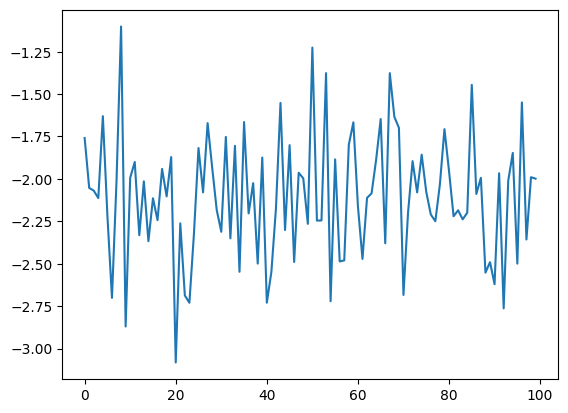

In [32]:
# evaluate the loss for many randomly sampled thetas
numruns = 100
np.random.seed(5)
manytheta0 = 1e-1*jnp.array(np.random.normal(size=numparams*numruns), dtype=np.float64).reshape((numruns, -1))

# use the many-theta version of the loss function,
# but only evaluate along one trajectory, to save memory and time
testloss = jvthetaloss(manytheta0, 0)

# plot log_{10} of the losses obtained from the random thetas
plt.plot(jnp.log(testloss)/jnp.log(10))
plt.show()

# pick the best theta
minind = jnp.argmin(testloss)
theta0 = manytheta0[minind]

In [34]:
# optimize using SciPy plus wrapped functions above (siobj & sigrad),
# starting from the initial theta0 chosen via random sampling
#theta0 = np.load('./tdcis_data/trainedtheta_perturbedNN_model_tdcis_dt0.008268au.npz')
#theta0 = trainedtheta
res = scipy.optimize.minimize( siobj, 
                               x0 = theta0,
                               method = 'trust-constr', 
                               jac = sigrad,
                               options = {'disp': True, 'verbose': 2, 'xtol': 1e-30, 'gtol': 1e-30, 'maxiter': 200} )
trainedtheta = res.x

In [34]:
# # after training, run some diagnostics

# # how far was the initial guess from the *true* theta?
# print( jnp.linalg.norm(theta0-thetatrue) )

# # how far is the final value of theta from the *true* theta?
# print( jnp.linalg.norm(res.x-thetatrue) )

In [60]:
trainedtheta = np.load('./tdcis_data/trainedtheta_perturbedtruepoly_model_tdcis_dt0.008268au_lowampdata.npz')

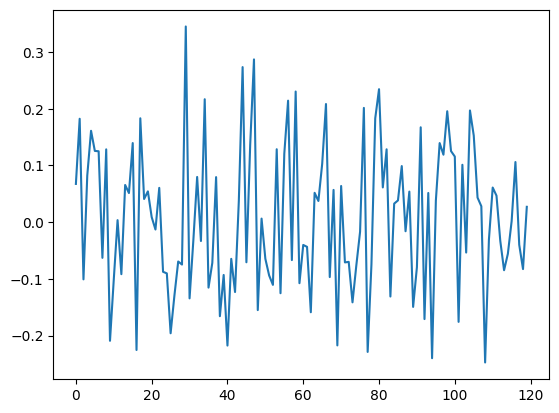

In [61]:
plt.plot(trainedtheta)

In [64]:
trainedtheta = np.zeros(numparams)

In [36]:
# with open('./tdcis_data/trainedtheta_perturbedtruepoly_model_tdcis_dt0.008268au_lowampdata.npz', 'wb') as f:
#     np.save(f, res.x)

In [65]:
def myinfo(ind):
    print(trnfreq[ind], trnamp[ind], trncycs[ind])

In [66]:
inds

array([140, 141, 142, 143, 144, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 165, 166, 167, 168, 169])

In [39]:
# for i in inds:
#     fig, axs = plt.subplots(2, 2, figsize=(10,8))
#     #axs[0,0].plot(mlprop[:,0,0].real, color='red')
#     axs[0,0].plot(jnp.real(trnden[i][:mynumsteps+1,0,0]),color='black')
#     axs[0,0].set_title('P'+str(0)+str(0)+' Real')

#     #axs[0,1].plot(mlprop[:,0,1].real, color='red')
#     axs[0,1].plot(jnp.real(trnden[i][:mynumsteps+1,0,1]),color='black')
#     axs[0,1].set_title('P'+str(0)+str(1)+' Real')

#     #axs[1,0].plot(mlprop[:,0,1].imag, color='red')
#     axs[1,0].plot(jnp.imag(trnden[i][:mynumsteps+1,0,1]),color='black')
#     axs[1,0].set_title('P'+str(0)+str(1)+' Imaginary')

#     #axs[1,1].plot(mlprop[:,1,1].real, color='red')
#     axs[1,1].plot(jnp.real(trnden[i][:mynumsteps+1,1,1]),color='black')
#     axs[1,1].set_title('P'+str(1)+str(1)+' Real')
#     #plt.savefig('./tdcasscf_data/linear_model_forcing_tdcasscf.pdf')
#     plt.legend(['ML Prop', 'Ground Truth'])
#     #plt.show()
#     #plt.close()

In [40]:
#trainedtheta = np.load('./tdcis_data/trainedtheta_perturbedNN_model_tdcis_dt0.008268au_finedata.npz')

In [67]:
trnden = jnp.array(np.load('./tdcis_data/tdcis_dt0.0082680.npz'))
trndentdhf = jnp.array(np.load('./tdhf_data/rt-tdhf_forcing_full_finedt.npz'))
trnfrq = jnp.array(np.load('./tdcis_data/tdcis_trnfreq_dt0.008268.npz'))
trnamp = jnp.array(np.load('./tdcis_data/tdcis_trnamp_dt0.008268.npz'))
trntme = jnp.array(np.load('./tdcis_data/tdcis_trntme_dt0.008268.npz'))

In [68]:
trnden.shape

(301, 10000, 2, 2)

In [69]:
inds

array([140, 141, 142, 143, 144, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 165, 166, 167, 168, 169])

In [72]:
i = 143
ic = trnden[i][0,:,:].reshape((-1))
mlprop = MMUT_Prop_HSB(trainedtheta, ic, dt=dt, ntvec=mynumsteps, tmeoff=trntme[i], fldfrq=trnfrq[i], fldamp=trnamp[i])

0.00017230605706575853


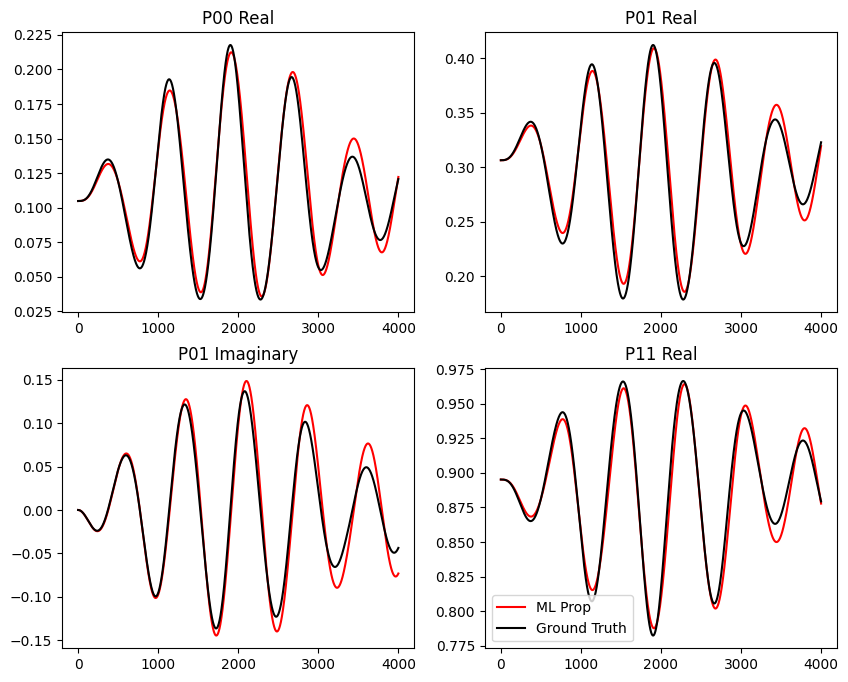

In [73]:
print(jnp.mean(jnp.abs(mlprop - trnden[i][:mynumsteps+1,:,:])**2))
fig, axs = plt.subplots(2, 2, figsize=(10,8))
axs[0,0].plot(mlprop[:,0,0].real, color='red')
axs[0,0].plot(jnp.real(trnden[i][:mynumsteps+1,0,0]),color='black')
axs[0,0].set_title('P'+str(0)+str(0)+' Real')

axs[0,1].plot(mlprop[:,0,1].real, color='red')
axs[0,1].plot(jnp.real(trnden[i][:mynumsteps+1,0,1]),color='black')
axs[0,1].set_title('P'+str(0)+str(1)+' Real')

axs[1,0].plot(mlprop[:,0,1].imag, color='red')
axs[1,0].plot(jnp.imag(trnden[i][:mynumsteps+1,0,1]),color='black')
axs[1,0].set_title('P'+str(0)+str(1)+' Imaginary')

axs[1,1].plot(mlprop[:,1,1].real, color='red')
axs[1,1].plot(jnp.real(trnden[i][:mynumsteps+1,1,1]),color='black')
axs[1,1].set_title('P'+str(1)+str(1)+' Real')
#plt.savefig('./tdcis_data/perturbedNN_0.5amp_1000steps_fit.pdf')
plt.legend(['ML Prop', 'Ground Truth'])
plt.show()
plt.close()

In [53]:
i = 145
ic = trnden[i][0,:,:].reshape((-1))
mlprop = MMUT_Prop_HSB(trainedtheta, ic, dt=dt, ntvec=mynumsteps, tmeoff=trntme[i], fldfrq=trnfrq[i], fldamp=trnamp[i])

0.03536816896409476


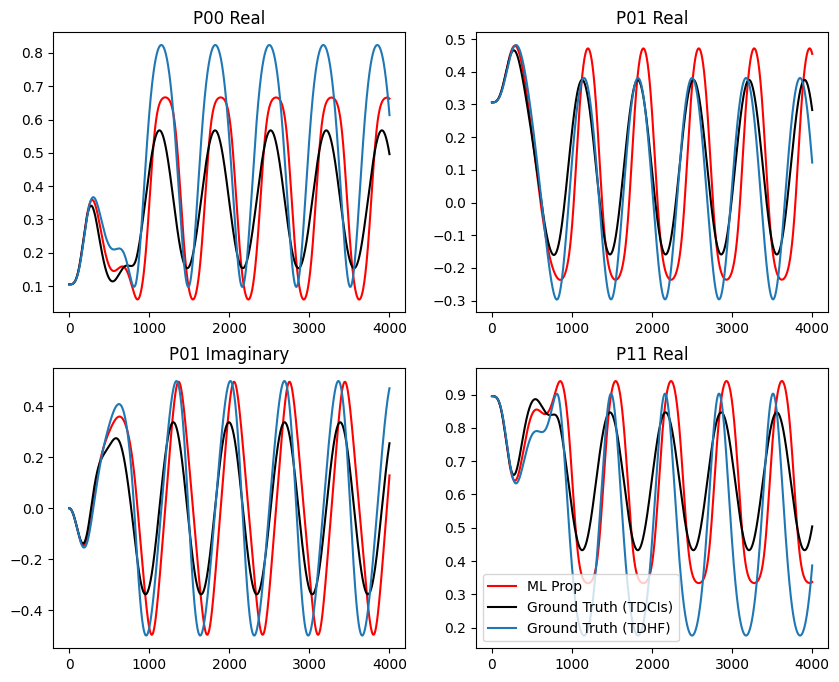

In [54]:
print(jnp.mean(jnp.abs(mlprop - trnden[i][:mynumsteps+1,:,:])**2))
fig, axs = plt.subplots(2, 2, figsize=(10,8))
axs[0,0].plot(mlprop[:,0,0].real, color='red')
axs[0,0].plot(jnp.real(trnden[i][:mynumsteps+1,0,0]),color='black')
axs[0,0].plot(jnp.real(trndentdhf[i][:mynumsteps+1,0,0]))
axs[0,0].set_title('P'+str(0)+str(0)+' Real')

axs[0,1].plot(mlprop[:,0,1].real, color='red')
axs[0,1].plot(jnp.real(trnden[i][:mynumsteps+1,0,1]),color='black')
axs[0,1].plot(jnp.real(trndentdhf[i][:mynumsteps+1,0,1]))
axs[0,1].set_title('P'+str(0)+str(1)+' Real')

axs[1,0].plot(mlprop[:,0,1].imag, color='red')
axs[1,0].plot(jnp.imag(trnden[i][:mynumsteps+1,0,1]),color='black')
axs[1,0].plot(jnp.imag(trndentdhf[i][:mynumsteps+1,0,1]))
axs[1,0].set_title('P'+str(0)+str(1)+' Imaginary')

axs[1,1].plot(mlprop[:,1,1].real, color='red')
axs[1,1].plot(jnp.real(trnden[i][:mynumsteps+1,1,1]),color='black')
axs[1,1].plot(jnp.real(trndentdhf[i][:mynumsteps+1,1,1]))
axs[1,1].set_title('P'+str(1)+str(1)+' Real')
#plt.savefig('./tdcasscf_data/linear_model_forcing_tdcasscf.pdf')
plt.legend(['ML Prop', 'Ground Truth (TDCIs)', 'Ground Truth (TDHF)'])
plt.show()
plt.close()

In [67]:
# # pick one training trajectory, and for this trajectory, 
# # plot the MSE at each point in time between
# # (1) mlprop, the result we get by propagating using the learned theta from optimization --- "res.x",
# # (2) the ground truth training trajectory
# for ii in range(140,160):
#     i = ii
#     ic = trnden[i][0,:,:].reshape((-1))
#     mlprop = MMUT_Prop_HSB(jnp.array(res.x), 
#                            ic, dt=dt, ntvec=mynumsteps, tmeoff=trntme[i], fldfrq=trnfrq[i], fldamp=trnamp[i])
#     #print(mlprop.shape)
#     #print(trnden[i][:mynumsteps+1,:,:].shape)
#     print(trnfrq[i],trnamp[i])
#     print(jnp.mean(jnp.abs(mlprop - trnden[i][:mynumsteps+1,:,:])**2))
#     print('=============================================')
#     plt.figure(figsize=(6,4))
#     plt.plot(jnp.mean(jnp.abs(mlprop-trnden[i][:mynumsteps+1,:,:])**2,axis=(1,2)))
# plt.show()

In [48]:
# compute and return all the densities **and** all the Hamiltonians along one trajectory!
def MMUT_Save_Ham(theta, initial_density, dt=0.08268, ntvec=2000,
                  tmeoff=1, fldfrq=1, fldamp=1, norm_direc=jnp.array([0.0,0.0,1.0])):
    tvec = dt*jnp.arange(ntvec)
    P0 = initial_density.reshape((drc, drc))
    propagated_dens = [P0]
    H0 = MLham(theta,0.0,P0.real, P0.imag,fldfrq,fldamp,tmeoff,norm_direc)
    H0 = H0[0] + 1.0j*H0[1]
    propagated_hams = [H0]
    evals, evecs = jnp.linalg.eigh(H0)
    U0 = evecs @ jnp.diag(jnp.exp(-1j*dt*evals)) @ evecs.conj().T
    P1 = U0 @ P0 @ U0.conj().T
    propagated_dens.append( P1 )
    def bodyfun(i, intup):
        dl, hl = intup
        P0 = dl[i, :, :]
        P1 = dl[i+1, :, :]
        H1 = MLham(theta,(i+1.0)*dt,P1.real, P1.imag,fldfrq,fldamp,tmeoff,norm_direc)
        H1 = H1[0] + 1.0j*H1[1]
        evals, evecs = jnp.linalg.eigh(H1)
        U1 = evecs @ jnp.diag(jnp.exp(-2j*dt*evals)) @ evecs.conj().T
        P2 = U1 @ P0 @ U1.conj().T
        return (dl.at[i+2].set( P2 ), hl.at[i+1].set( H1 ))
    
    alldens = jnp.concatenate([jnp.stack(propagated_dens), jnp.zeros((ntvec-1, drc, drc))], axis=0)
    allhams = jnp.concatenate([jnp.stack(propagated_hams), jnp.zeros((ntvec-1, drc, drc))], axis=0)
    fdh = lax.fori_loop(0, ntvec-1, bodyfun, (alldens, allhams))
    
    return fdh

In [49]:
# compute mean square commutator errors for one trajectory
def commutatorerror(theta, i):
    ic = trnden[i][0,:,:].reshape((-1))
    mynumsteps = 4000
    mydenham = MMUT_Save_Ham(theta, ic, dt=dt, ntvec=mynumsteps, tmeoff=trntme[i], fldfrq=trnfrq[i], fldamp=trnamp[i])
    trdenham = MMUT_Save_Ham(thetatrue, ic, dt=dt, ntvec=mynumsteps, tmeoff=trntme[i], fldfrq=trnfrq[i], fldamp=trnamp[i])

    mycom = jnp.einsum('aij,ajk->aik',mydenham[1],mydenham[0][:-1,:,:]) - jnp.einsum('aij,ajk->aik',mydenham[0][:-1,:,:],mydenham[1])
    trcom = jnp.einsum('aij,ajk->aik',trdenham[1],trdenham[0][:-1,:,:]) - jnp.einsum('aij,ajk->aik',trdenham[0][:-1,:,:],trdenham[1])

    return jnp.mean(jnp.square(jnp.abs(mycom - trcom)))

In [50]:
# many trajectory version
vcommutatorerror = vmap(commutatorerror, (None, 0))
jvcommutatorerror = jit(vcommutatorerror)

In [51]:
# evaluate commutator errors on training set
allcommerrs = jvcommutatorerror(jnp.array(res.x), jnp.arange(100))

InconclusiveDimensionOperation: Cannot divide evenly the sizes of shapes (8,) and (4, 4)

In [ ]:
# min, mean, and max commutator error
print(jnp.min(allcommerrs), jnp.mean(allcommerrs), jnp.max(allcommerrs))